# Zillow Project
### - By Jeff Akins

In [1]:
# Imports:
import zillow_wrangle as zw
import zillow_models as zm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

import warnings
warnings.filterwarnings("ignore")

### Acquire
- I created a series of functions to acquire and clean the zillow data, which are located in the zillow_wrangle.py file. They take in all of the single unit properties (code 261 from the propertylandusetypeid column on the properties_2017 table in the zillow data set) that were sold between 1 May and 1 Sept of 2017 (based on the predictions_2017 table) into a Pandas dataFrame. I then add on a column for zipcodes and average home price per zipcode. 

In [2]:
zillow = zw.wrangle_zillow()
zillow.head(3)

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,fips,zipcode,zipcode_avg_price
0,3,2.0,1772,418763.0,1978,4464.42,6111,97089,408141
1,4,2.0,1896,94711.0,1957,1017.10,6111,97089,408141
2,5,4.5,3980,769907.0,1999,8650.36,6111,97089,408141


In [3]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29789 entries, 0 to 29788
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           29789 non-null  int64  
 1   bathrooms          29789 non-null  float64
 2   sqft               29789 non-null  int64  
 3   tax_value          29789 non-null  float64
 4   year_built         29789 non-null  int64  
 5   tax_amount         29789 non-null  float64
 6   fips               29789 non-null  int64  
 7   zipcode            29789 non-null  int64  
 8   zipcode_avg_price  29789 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 2.3 MB


### Initial Plots

<Figure size 648x432 with 0 Axes>

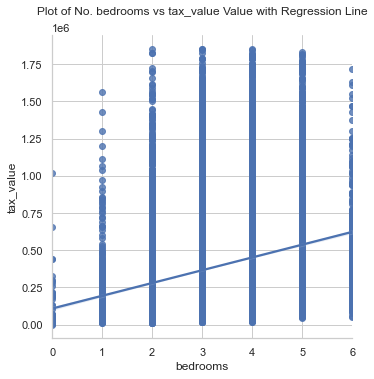

In [5]:
zw.initial_plot(zillow, 'bedrooms', 'tax_value')

<Figure size 648x432 with 0 Axes>

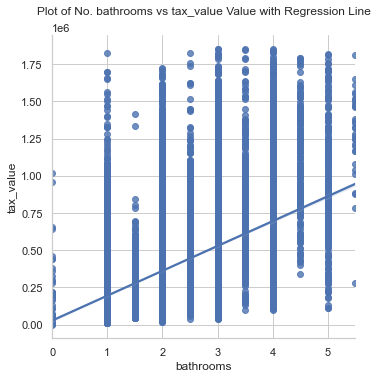

In [7]:
zw.initial_plot(zillow, 'bathrooms', 'tax_value')

<Figure size 648x432 with 0 Axes>

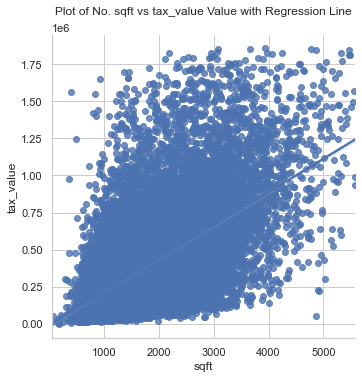

In [8]:
zw.initial_plot(zillow, 'sqft', 'tax_value')

<Figure size 648x432 with 0 Axes>

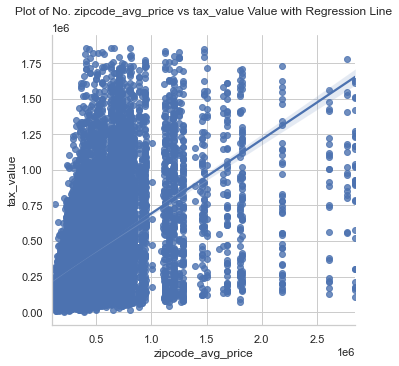

In [9]:
zw.initial_plot(zillow, 'zipcode_avg_price', 'tax_value')

#### Findings:
- It appears that there are linear relationships between the target and bedrooms, bathrooms, sqft, and average price per zipcode

### Scaling
- I then scale the data using a min-max scalar and drop any colums that I do not plan to use.
- List of Columns that are scaled:
 - bedrooms
 - bathrooms
 - sqft
 - zipcode_avg_price

In [12]:
# First split into train, validate, test
train, validate, test = zw.train_validate_test_split(zillow, seed=123)
print('Train shape: ', train.shape)
print('Validate shape: ', validate.shape)
print('Test shape: ', test.shape)

Train shape:  (16755, 8)
Validate shape:  (5586, 8)
Test shape:  (7448, 8)


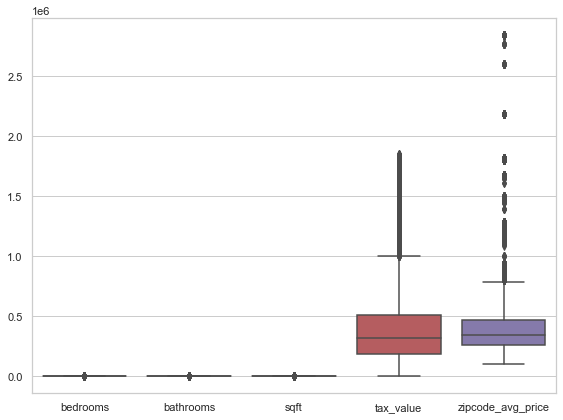

In [6]:
plt.figure(figsize=(8,6))

sns.boxplot(data=zillow.drop(columns=['fips', 'zipcode', 'tax_amount', 'year_built']))
# mitigate overlap
plt.tight_layout()
plt.show()

### Explore

### Feature Engineer

### Model

### Evaluate